# EDA on Employee Retention - Aditya - GCD - Capstone

## Table of Content

1. [Problem Statement](#section1)<br>
2. [Data Loading and Description](#section2)<br>
3. [Exploratory Data Analysis](#section3)<br>


<a id = section1></a>

## 1. Project Goals

Your client for this project is the HR Department at a software company.

    They want to try a new initiative to retain employees.
    The idea is to use data to predict whether an employee is likely to leave.
    Once these employees are identified, HR can be more proactive in reaching out to them before it's too late.
    They only want to deal with the data that is related to permanent employees.

Current Practice
Once an employee leaves, he or she is taken an interview with the name “exit interview” and shares reasons for leaving. The HR Department then tries and learns insights from the interview and makes changes accordingly.

This suffers from the following problems:

    This approach is that it's too haphazard. The quality of insight gained from an interview depends heavily on the skill of the interviewer.
    The second problem is these insights can't be aggregated and interlaced across all employees who have left.
    The third is that it is too late by the time the proposed policy changes take effect.


The HR department has hired you as data science consultants. They want to supplement their exit interviews with a more proactive approach.


### Your Role

    You are given datasets of past employees and their status (still employed or already left).
    Your task is to build a classification model using the datasets.
    Because there was no machine learning model for this problem in the company, you don’t have quantifiable win condition. You need to build the best possible model.


#### Problem Specifics
    Deliverable: Predict whether an employee will stay or leave.
    Machine learning task: Classification
    Target variable: Status (Employed/Left)
    Win condition: N/A (best possible model)

<a id = section2></a>

## 2. Data Description

The Business Intelligence Analysts of the Company provided you three datasets that contain information about past employees and their status (still employed or already left).

    department_data

    This dataset contains information about each department. The schema of the dataset is as follows:
        dept_id – Unique Department Code
        dept_name – Name of the Department
        dept_head – Name of the Head of the Department

    employee_details_data

    This dataset consists of Employee ID, their Age, Gender and Marital Status. The schema of this dataset is as follows:
        employee_id – Unique ID Number for each employee
        age – Age of the employee
        gender – Gender of the employee
        marital_status – Marital Status of the employee

    employee_data

    This dataset consists of each employee’s Administrative Information, Workload Information, Mutual Evaluation Information and Status.

    Target variable
        status – Current employment status (Employed / Left)

    Administrative information
        department – Department to which the employees belong(ed) to
        salary – Salary level with respect to rest of their department
        tenure – Number of years at the company
        recently_promoted – Was the employee promoted in the last 3 years?
        employee_id – Unique ID Number for each employee

    Workload information
        n_projects – Number of projects employee has worked on
        avg_monthly_hrs – Average number of hours worked per month

    Mutual evaluation information
        satisfaction – Score for employee’s satisfaction with the company (higher is better)
        last_evaluation – Score for most recent evaluation of employee (higher is better)
        filed_complaint – Has the employee filed a formal complaint in the last 3 years?


<a id = section3></a>

## 3. EDA

#### Data Source
Download the DataSets onto Python by connecting to the below provided MySQL instance.
                      
    host        'projects.insaid.co'
    user 	   'student'
    passwd      'student'
    database    'Capstone2'

In [32]:
# Database 
import mysql.connector
from mysql.connector import Error
from collections import Counter

# ML
import pandas as pd
import numpy as np

# sklearn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Plotting
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [33]:
tables = ['department_data', 'employee_details_data', 'employee_data']

In [34]:
try:
    mySQLconnection = mysql.connector.connect(host='projects.insaid.co',
                             database='Capstone2',
                             user='student',
                             password='student')
    
    if mySQLconnection.is_connected():
        db_Info = mySQLconnection.get_server_info()
        print("Connected to MySQL database... MySQL Server version on ",db_Info)
        cursor = mySQLconnection.cursor()
        cursor.execute("select database();")
        database = cursor.fetchone()
        print ("Your connected to - ", database)
        # for table in tables:
            # cursor.execute(sql_select_Query)
            # records = cursor.fetchall()
            # print (records)
        sql_select_Query = "select * from department_data"
        SQL_Query = pd.read_sql_query(sql_select_Query, mySQLconnection)
        df_departmentData = pd.DataFrame(SQL_Query)
        print(df_departmentData.head(3))
        
        sql_select_Query = "select * from employee_details_data"
        SQL_Query = pd.read_sql_query(sql_select_Query, mySQLconnection)
        df_employeeDetailsData = pd.DataFrame(SQL_Query)
        print(df_employeeDetailsData.head(3))

        sql_select_Query = "select * from employee_data"
        SQL_Query = pd.read_sql_query(sql_select_Query, mySQLconnection)
        df_employeeData = pd.DataFrame(SQL_Query)
        print(df_employeeData.head(3))
except Error as e :
    print ("Error while connecting to MySQL", e)
finally:
    #closing database connection.
    if(mySQLconnection .is_connected()):
        mySQLconnection.close()
        print("MySQL connection is closed")

Connected to MySQL database... MySQL Server version on  5.7.25-0ubuntu0.18.04.2
Your connected to -  ('Capstone2',)
  dept_id dept_name        dept_head
0  D00-IT        IT       Henry Adey
1  D00-SS     Sales  Edward J Bayley
2  D00-TP      Temp  Micheal Zachrey
   employee_id  age  gender marital_status
0       113558   43    Male        Married
1       112256   24  Female      Unmarried
2       112586   22  Female      Unmarried
   avg_monthly_hrs department  filed_complaint  last_evaluation  n_projects  \
0            246.0       None              NaN         0.866838           6   
1            134.0       None              NaN         0.555718           2   
2            156.0     D00-SS              1.0         0.474082           2   

   recently_promoted  salary  satisfaction status  tenure  employee_id  
0                NaN  medium      0.134415   Left     4.0       124467  
1                NaN     low      0.511041   Left     3.0       112210  
2                NaN  medium

In [35]:
print (df_departmentData.shape)
print (df_employeeDetailsData.shape)
print (df_employeeData.shape)

(11, 3)
(14245, 4)
(14150, 11)


In [36]:
df_empData = pd.merge(df_employeeDetailsData, df_employeeData, how='outer', on="employee_id")

In [37]:
print (df_empData.head())
print (df_empData.shape)

   employee_id   age  gender marital_status  avg_monthly_hrs department  \
0       113558  43.0    Male        Married            111.0     D00-PR   
1       112256  24.0  Female      Unmarried            201.0     D00-MN   
2       112586  22.0  Female      Unmarried            239.0     D00-SS   
3       108071  36.0    Male        Married            151.0     D00-PR   
4       116915  38.0    Male        Married            259.0        -IT   

   filed_complaint  last_evaluation  n_projects  recently_promoted  salary  \
0              NaN         0.753977         5.0                1.0  medium   
1              NaN         0.964453         3.0                NaN  medium   
2              NaN         0.756458         3.0                NaN     low   
3              NaN         0.608282         5.0                NaN  medium   
4              NaN         0.749206         4.0                NaN  medium   

   satisfaction    status  tenure  
0      0.921208  Employed     4.0  
1      0

In [38]:
df = df_empData.merge(df_departmentData, how='outer', left_on='department', right_on='dept_id')

In [39]:
print (df.head())
print (df.shape)

   employee_id   age gender marital_status  avg_monthly_hrs department  \
0       113558  43.0   Male        Married            111.0     D00-PR   
1       108071  36.0   Male        Married            151.0     D00-PR   
2       110888  42.0   Male        Married            152.0     D00-PR   
3       115694  26.0   Male      Unmarried            167.0     D00-PR   
4       107767  43.0   Male        Married            174.0     D00-PR   

   filed_complaint  last_evaluation  n_projects  recently_promoted  salary  \
0              NaN         0.753977         5.0                1.0  medium   
1              NaN         0.608282         5.0                NaN  medium   
2              NaN         0.673508         6.0                NaN  medium   
3              NaN         0.874656         3.0                NaN  medium   
4              1.0         0.634783         5.0                NaN  medium   

   satisfaction    status  tenure dept_id    dept_name    dept_head  
0      0.921208 

In [40]:
df = df.drop('department', 1)

In [41]:
df.to_csv('Employee_original_data.csv')
print (df.head())
print (df.shape)

   employee_id   age gender marital_status  avg_monthly_hrs  filed_complaint  \
0       113558  43.0   Male        Married            111.0              NaN   
1       108071  36.0   Male        Married            151.0              NaN   
2       110888  42.0   Male        Married            152.0              NaN   
3       115694  26.0   Male      Unmarried            167.0              NaN   
4       107767  43.0   Male        Married            174.0              1.0   

   last_evaluation  n_projects  recently_promoted  salary  satisfaction  \
0         0.753977         5.0                1.0  medium      0.921208   
1         0.608282         5.0                NaN  medium      0.210300   
2         0.673508         6.0                NaN  medium      0.720369   
3         0.874656         3.0                NaN  medium      0.575996   
4         0.634783         5.0                NaN  medium      0.208138   

     status  tenure dept_id    dept_name    dept_head  
0  Employed 

### Data Pre-processing and Cleaning

In [42]:
df.columns

Index(['employee_id', 'age', 'gender', 'marital_status', 'avg_monthly_hrs',
       'filed_complaint', 'last_evaluation', 'n_projects', 'recently_promoted',
       'salary', 'satisfaction', 'status', 'tenure', 'dept_id', 'dept_name',
       'dept_head'],
      dtype='object')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14279 entries, 0 to 14278
Data columns (total 16 columns):
employee_id          14279 non-null int64
age                  14274 non-null float64
gender               14274 non-null object
marital_status       14274 non-null object
avg_monthly_hrs      14150 non-null float64
filed_complaint      2046 non-null float64
last_evaluation      12663 non-null float64
n_projects           14150 non-null float64
recently_promoted    297 non-null float64
salary               14150 non-null object
satisfaction         14000 non-null float64
status               14150 non-null object
tenure               14000 non-null float64
dept_id              13236 non-null object
dept_name            13236 non-null object
dept_head            13236 non-null object
dtypes: float64(8), int64(1), object(7)
memory usage: 1.9+ MB


In [44]:
df.describe(include='all')

,employee_id,age,gender,marital_status,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,dept_id,dept_name,dept_head
count,14279.000000,14274.000000,14274,14274,14150.000000,2046.0,12663.000000,14150.000000,297.0,14150,14000.000000,14150,14000.000000,13236,13236,13236
unique,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,3,NaN,2,NaN,11,11,11
top,NaN,NaN,Male,Unmarried,NaN,NaN,NaN,NaN,NaN,low,NaN,Employed,NaN,D00-SS,Sales,Edward J Bayley
freq,NaN,NaN,9399,7298,NaN,NaN,NaN,NaN,NaN,6906,NaN,10784,NaN,3905,3905,3905
mean,112083.497864,32.892532,NaN,NaN,199.994346,1.0,0.718399,3.778304,1.0,NaN,0.621212,NaN,3.499357,NaN,NaN,NaN
std,8748.714222,9.974750,NaN,NaN,50.833697,0.0,0.173108,1.250162,0.0,NaN,0.250482,NaN,1.462584,NaN,NaN,NaN
min,0.000000,22.000000,NaN,NaN,49.000000,1.0,0.316175,1.000000,1.0,NaN,0.040058,NaN,2.000000,NaN,NaN,NaN
25%,105774.500000,24.000000,NaN,NaN,155.000000,1.0,0.563711,3.000000,1.0,NaN,0.450356,NaN,3.000000,NaN,NaN,NaN
50%,111296.000000,29.000000,NaN,NaN,199.000000,1.0,0.724731,4.000000,1.0,NaN,0.652394,NaN,3.000000,NaN,NaN,NaN
75%,116653.500000,41.000000,NaN,NaN,245.000000,1.0,0.871409,5.000000,1.0,NaN,0.824925,NaN,4.000000,NaN,NaN,NaN


In [45]:
df.isnull().sum()[df.isnull().sum() !=0]

age                      5
gender                   5
marital_status           5
avg_monthly_hrs        129
filed_complaint      12233
last_evaluation       1616
n_projects             129
recently_promoted    13982
salary                 129
satisfaction           279
status                 129
tenure                 279
dept_id               1043
dept_name             1043
dept_head             1043
dtype: int64

In [46]:
df.shape

(14279, 16)

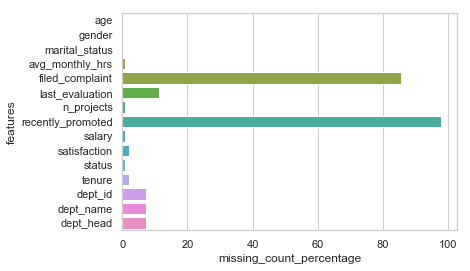

In [47]:
missing = df.isnull().sum()[df.isnull().sum() !=0]
missing = pd.DataFrame(missing.reset_index())
missing.rename(columns={'index':'features',0:'missing_count'}, inplace = True)
missing['missing_count_percentage'] = ((missing['missing_count'])/df.shape[0])*100
plt.figure()
sns.barplot(y = missing['features'], x = missing['missing_count_percentage'])

In [48]:
# Drop the two columns with large number of missing elements
df.drop(['filed_complaint','recently_promoted'], axis=1, inplace = True)

In [49]:
# Drop records with missing elements
df.dropna(subset=['age', 'gender', 'marital_status', 'avg_monthly_hrs', 'last_evaluation', 'n_projects', 'salary', 'satisfaction', 'tenure', 'dept_id', 'dept_name', 'dept_head'], inplace = True)

In [50]:
df.isnull().sum()[df.isnull().sum() !=0]

Series([], dtype: int64)

In [51]:
# Drop Records with Invalid Employee ID
df = df[df.employee_id > 0]

In [52]:
# Check for duplicates
df[df.duplicated()].count()

employee_id        29
age                29
gender             29
marital_status     29
avg_monthly_hrs    29
last_evaluation    29
n_projects         29
salary             29
satisfaction       29
status             29
tenure             29
dept_id            29
dept_name          29
dept_head          29
dtype: int64

In [53]:
# Drop Duplicates
df.drop_duplicates(inplace = True) 

In [54]:
CATEGORICAL_COLUMNS = ["gender", "marital_status", "salary", "status"]

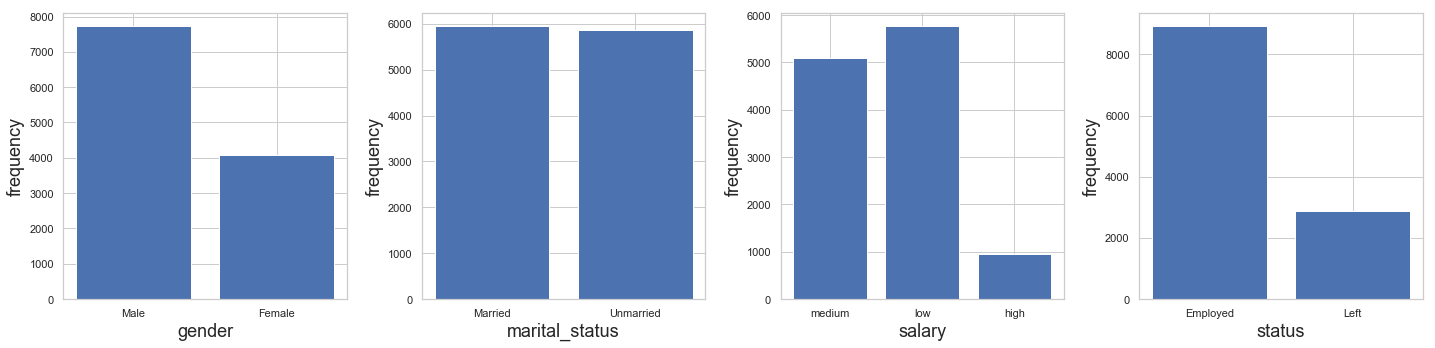

In [55]:
def plot_categoricals(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        cnt = Counter(data[col])
        keys = list(cnt.keys())
        vals = list(cnt.values())
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.bar(range(len(keys)), vals, align="center")
        plt.xticks(range(len(keys)), keys)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_categoricals(df[CATEGORICAL_COLUMNS])

In [56]:
CONTINUOUS_COLUMNS = ["age", "avg_monthly_hrs", "last_evaluation", "n_projects", "satisfaction", "tenure"]

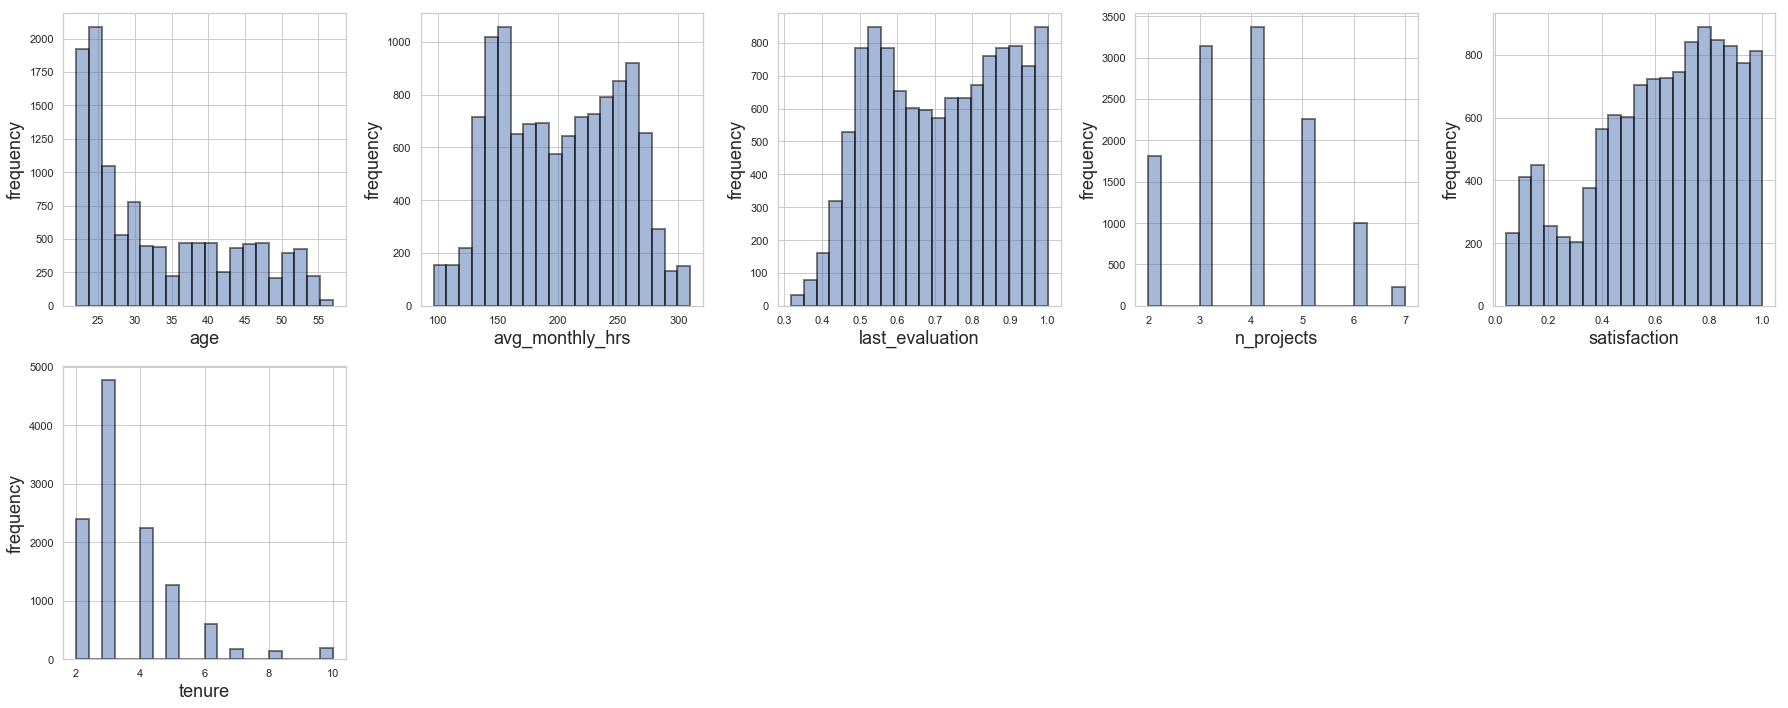

In [57]:
def plot_histgrams(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        X = data[col].dropna()
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.hist(X, bins=20, alpha=0.5, \
                 edgecolor="black", linewidth=2.0)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_histgrams(df[CONTINUOUS_COLUMNS])

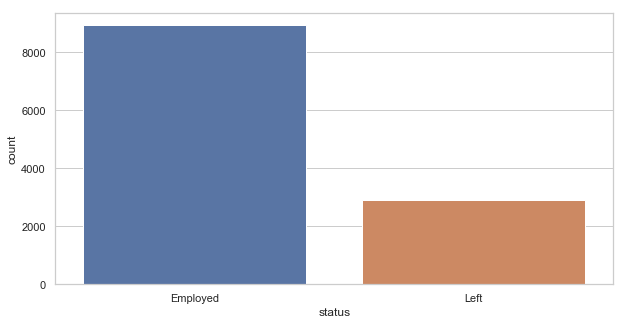

In [58]:
axis1 = plt.subplots(1,1,figsize=(10,5))
sns.countplot(x='status',data=df)

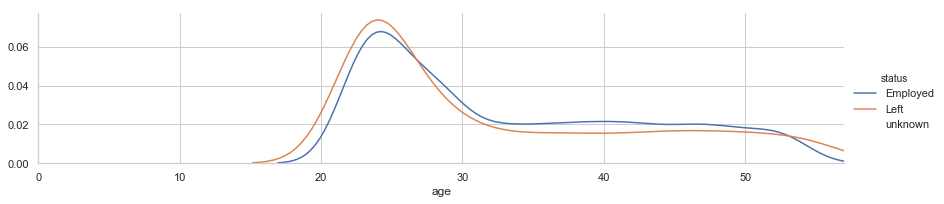

In [59]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left', 'unknown'])
facet.map(sns.kdeplot,'age')
facet.set(xlim=(0, df['age'].max()))
facet.add_legend()

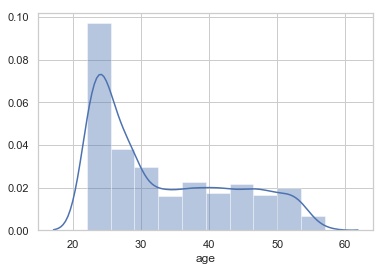

In [60]:
sns.distplot(df["age"],bins=10,kde=True)

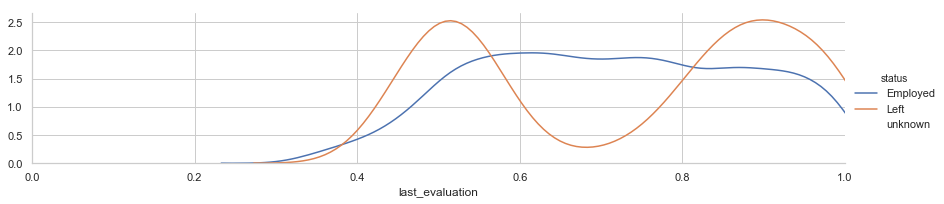

In [61]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left', 'unknown'])
facet.map(sns.kdeplot,'last_evaluation')
facet.set(xlim=(0, df['last_evaluation'].max()))
facet.add_legend()

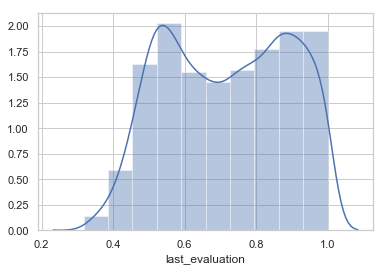

In [62]:
sns.distplot(df["last_evaluation"],bins=10,kde=True)

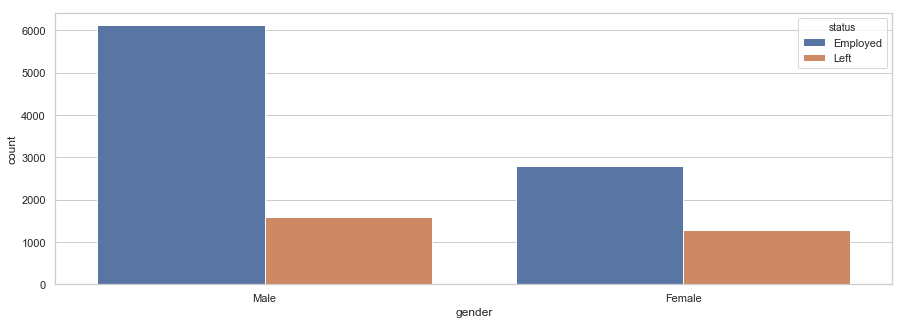

In [63]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='gender', hue="status", data=df, ax=axis1)

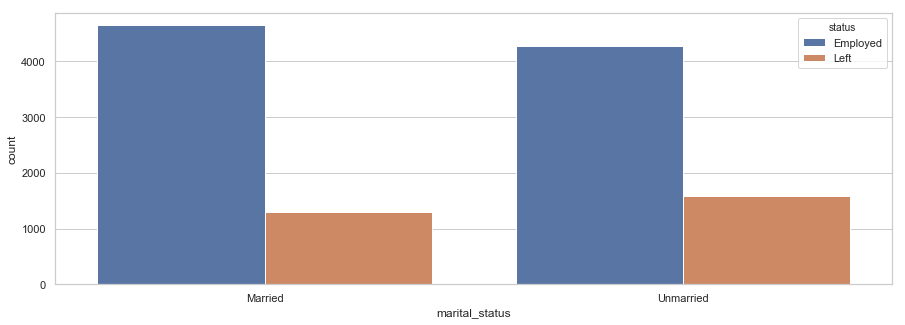

In [64]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='marital_status', hue="status", data=df, ax=axis1)

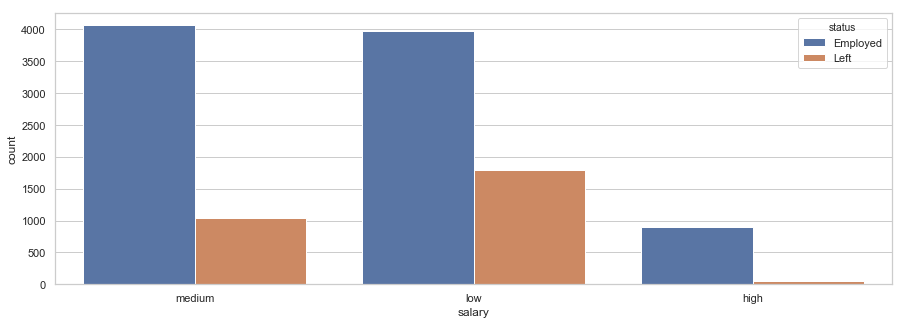

In [65]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='salary', hue="status", data=df, ax=axis1)

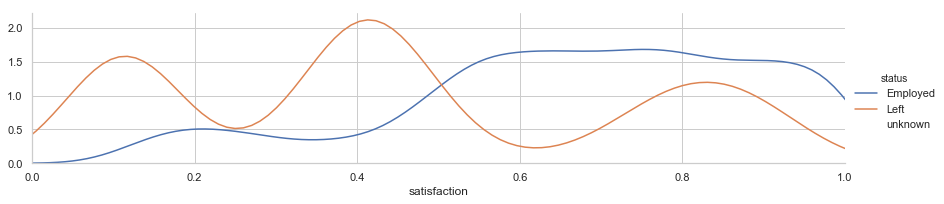

In [66]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left', 'unknown'])
facet.map(sns.kdeplot,'satisfaction')
facet.set(xlim=(0, df['satisfaction'].max()))
facet.add_legend()

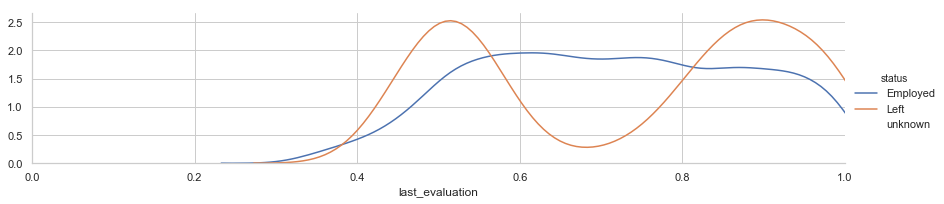

In [67]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left', 'unknown'])
facet.map(sns.kdeplot,'last_evaluation')
facet.set(xlim=(0, df['last_evaluation'].max()))
facet.add_legend()

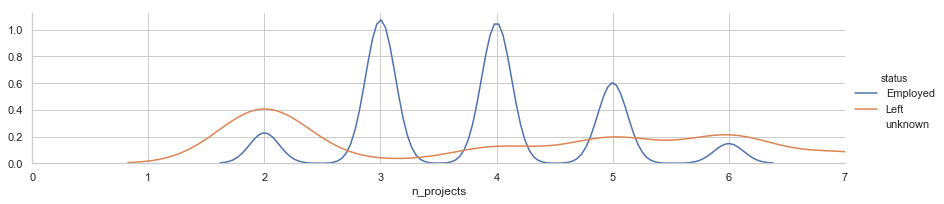

In [68]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left', 'unknown'])
facet.map(sns.kdeplot,'n_projects')
facet.set(xlim=(0, df['n_projects'].max()))
facet.add_legend()

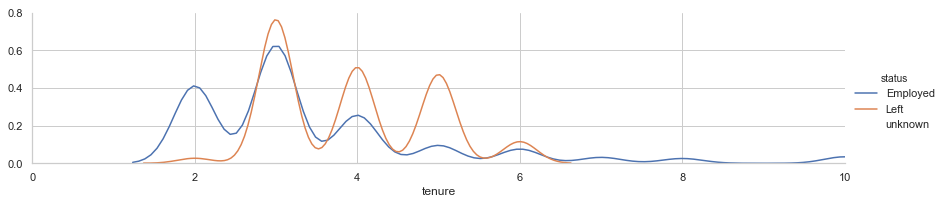

In [69]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left', 'unknown'])
facet.map(sns.kdeplot,'tenure')
facet.set(xlim=(0, df['tenure'].max()))
facet.add_legend()

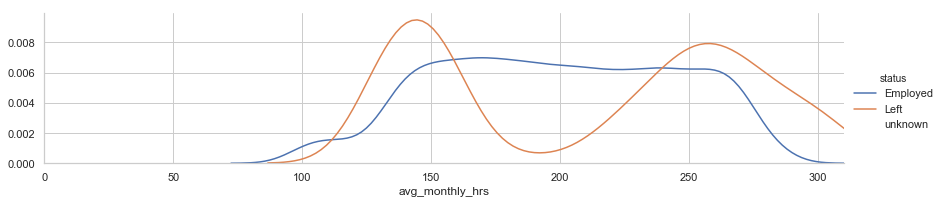

In [70]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left', 'unknown'])
facet.map(sns.kdeplot,'avg_monthly_hrs')
facet.set(xlim=(0, df['avg_monthly_hrs'].max()))
facet.add_legend()

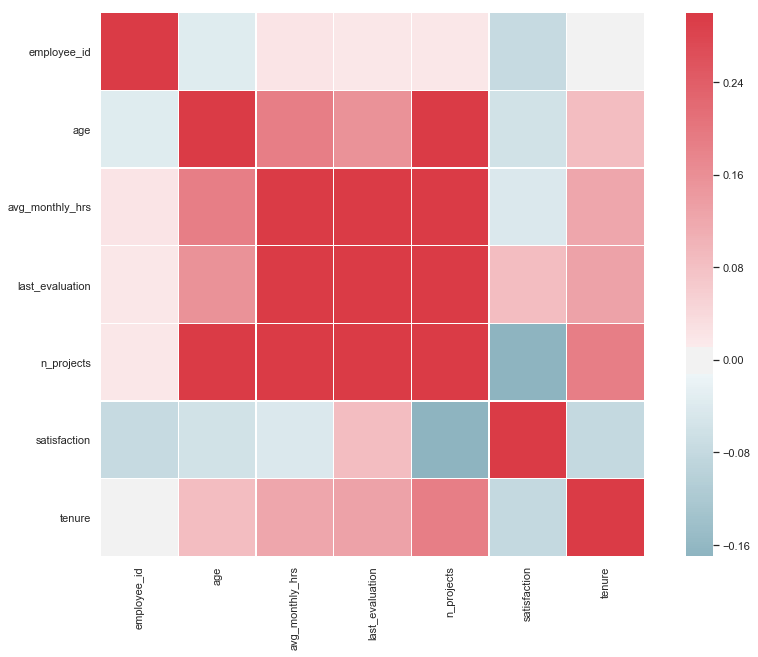

In [71]:
corr = df.corr()
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

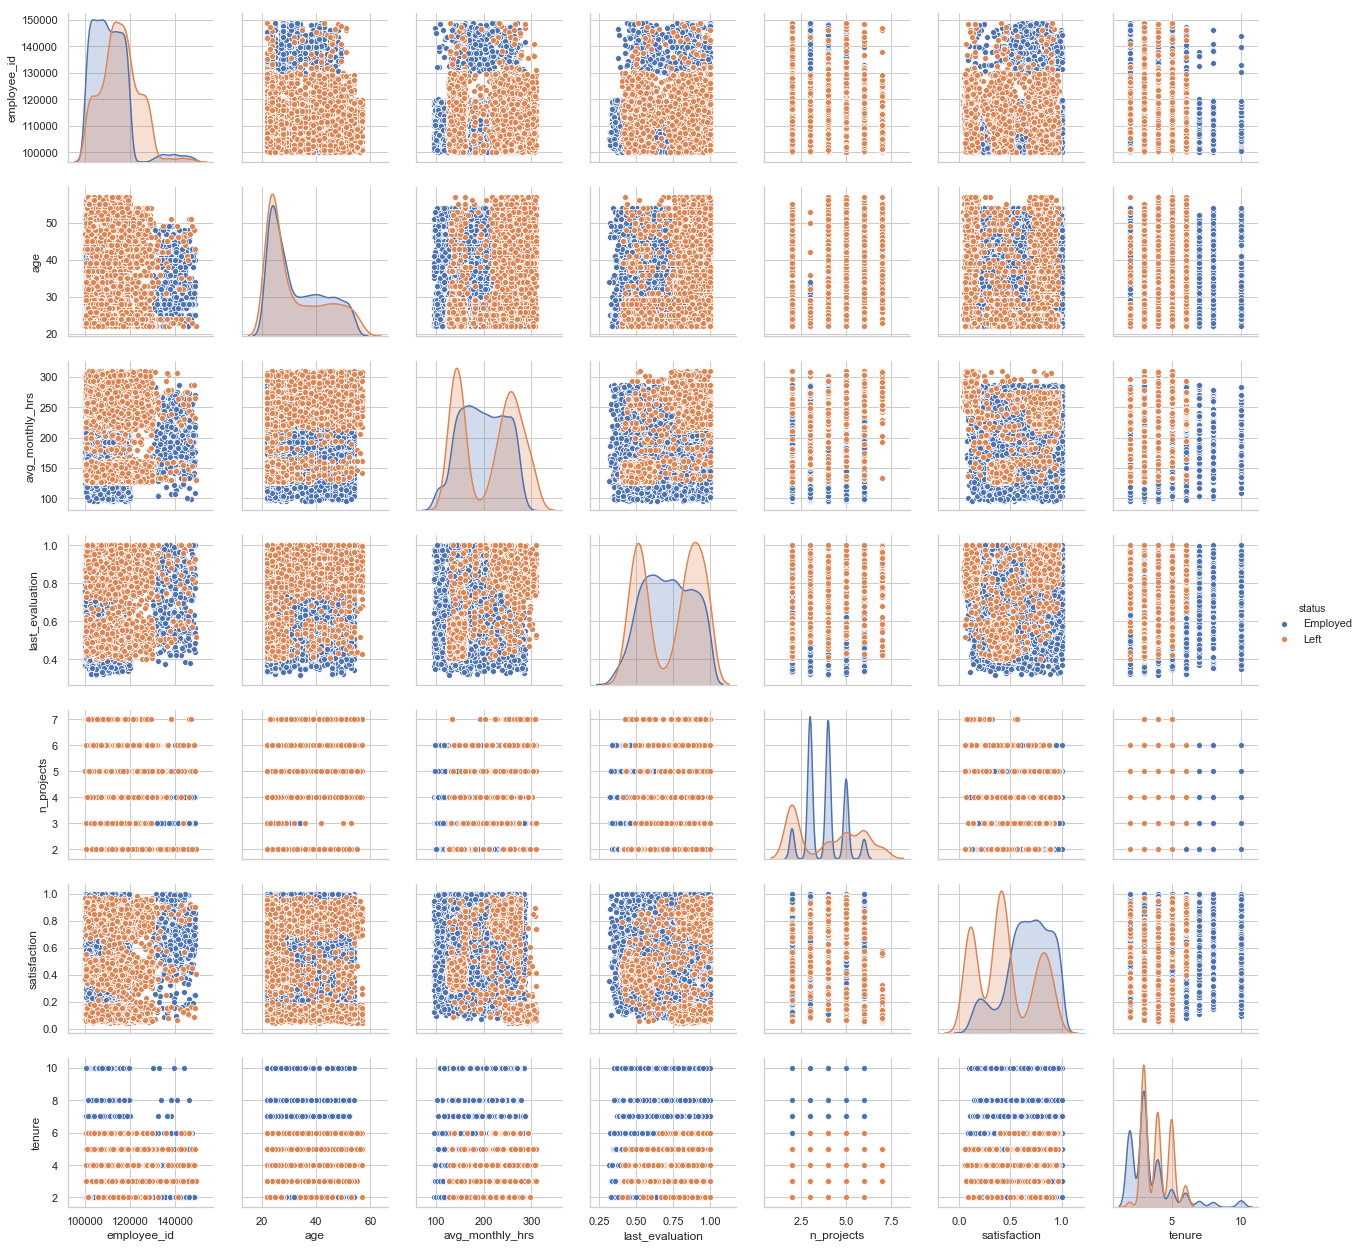

In [72]:
sns.pairplot(data=df,kind='scatter', hue='status')

C:\Users\Aditya\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


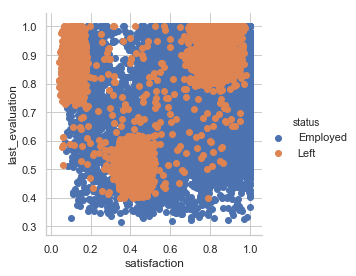

In [73]:
sns.FacetGrid(df, hue="status", size=4) \
    .map(plt.scatter, "satisfaction", "last_evaluation") \
    .add_legend();
plt.show();

C:\Users\Aditya\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


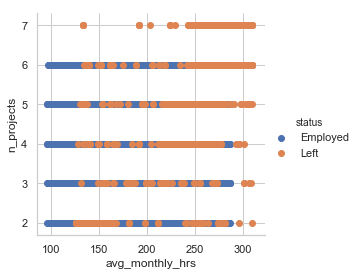

In [74]:
sns.FacetGrid(df, hue="status", size=4) \
    .map(plt.scatter, "avg_monthly_hrs", "n_projects") \
    .add_legend();
plt.show();

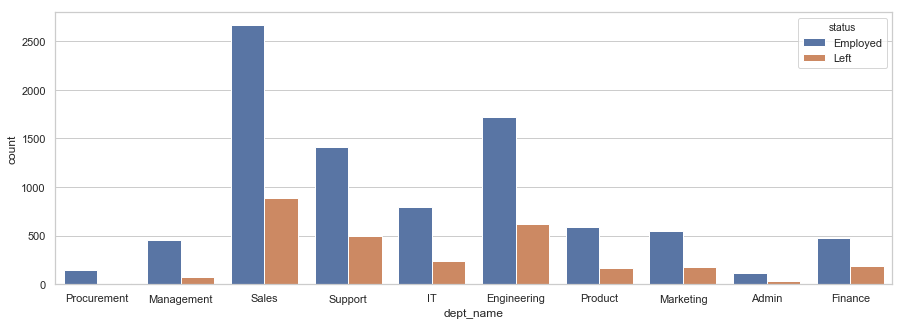

In [75]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='dept_name', hue="status", data=df, ax=axis1)

In [76]:
departments = df['dept_name'].unique()
departments = departments[departments != 'unknown']
departments

array(['Procurement', 'Management', 'Sales', 'Support', 'IT',
       'Engineering', 'Product', 'Marketing', 'Admin', 'Finance'],
      dtype=object)

In [77]:
print ("Department  - Employees % - Dept. Attrition % - Overall Attrition %")
for dept in departments:
    print ("%-11s - %-11.2f - %-17.2f - %-6.2f" %(dept, \
                                        df[(df['dept_name'] == dept)]['dept_name'].count()/df['dept_name'].count() * 100, \
                                        df[(df['dept_name'] == dept) & (df['status'] == "Left")]['dept_name'].count()/df[(df['dept_name'] == dept)]['dept_name'].count() * 100, \
                                        df[(df['dept_name'] == dept) & (df['status'] == "Left")]['dept_name'].count()/df[(df['status'] == "Left")]['dept_name'].count() * 100))

Department  - Employees % - Dept. Attrition % - Overall Attrition %
Procurement - 1.32        - 9.62              - 0.52  
Management  - 4.52        - 13.88             - 2.56  
Sales       - 30.06       - 24.97             - 30.67 
Support     - 16.11       - 25.81             - 17.00 
IT          - 8.73        - 23.20             - 8.27  
Engineering - 19.75       - 26.38             - 21.29 
Product     - 6.46        - 22.31             - 5.88  
Marketing   - 6.18        - 24.83             - 6.27  
Admin       - 1.30        - 22.22             - 1.18  
Finance     - 5.59        - 27.88             - 6.37  


In [78]:
employee_count_by_department = np.zeros(len(departments))
dept_attrition = np.zeros(len(departments))
overall_attrition = np.zeros(len(departments))
i = 0
for dept in departments:
    employee_count_by_department[i] = df[(df['dept_name'] == dept)]['dept_name'].count()/df['dept_name'].count() * 100
    dept_attrition[i] = df[(df['dept_name'] == dept) & (df['status'] == "Left")]['dept_name'].count()/df[(df['dept_name'] == dept)]['dept_name'].count() * 100
    overall_attrition[i] = df[(df['dept_name'] == dept) & (df['status'] == "Left")]['dept_name'].count()/df[(df['status'] == "Left")]['dept_name'].count() * 100
    i += 1

attrition_df = pd.DataFrame({'Employee_Percentage': employee_count_by_department, 'Dept_attrition': dept_attrition, 'Overall_attrition': overall_attrition}, index=departments)
attrition_df

,Employee_Percentage,Dept_attrition,Overall_attrition
Procurement,1.321586,9.615385,0.519211
Management,4.515419,13.883677,2.561440
Sales,30.057608,24.971815,30.668051
Support,16.113182,25.814932,16.995500
IT,8.725856,23.203883,8.272759
Engineering,19.747543,26.383526,21.287643
Product,6.455439,22.309711,5.884389
Marketing,6.175873,24.828532,6.265144
Admin,1.296171,22.222222,1.176878
Finance,5.591325,27.878788,6.368986


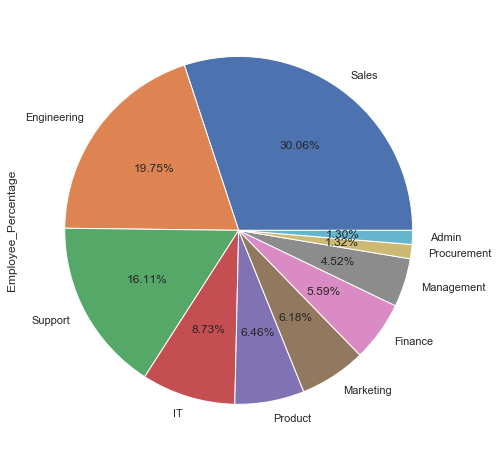

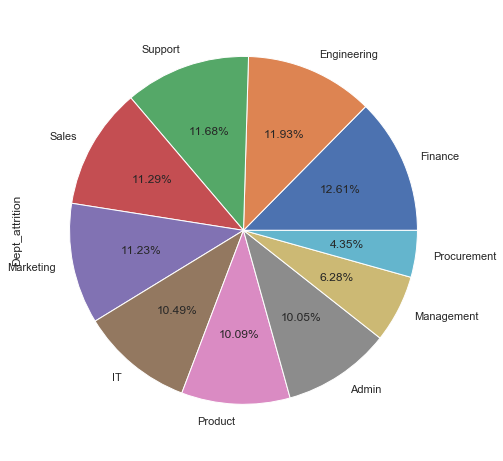

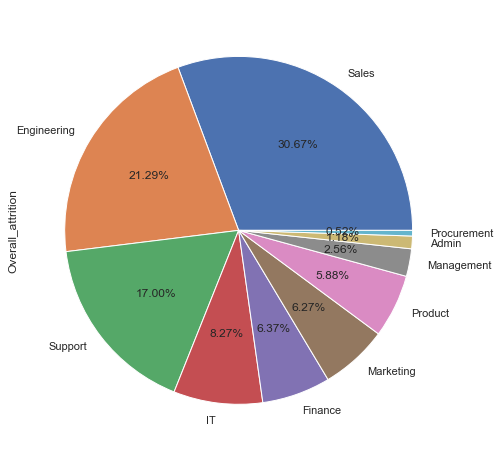

In [83]:
attrition_df.sort_values(by='Employee_Percentage', ascending=False).plot.pie('Employee_Percentage', legend=False, autopct='%.2f%%', figsize=(8,8))
attrition_df.sort_values(by='Dept_attrition', ascending=False).plot.pie('Dept_attrition', legend=False, autopct='%.2f%%', figsize=(8,8))
attrition_df.sort_values(by='Overall_attrition', ascending=False).plot.pie('Overall_attrition', legend=False, autopct='%.2f%%', figsize=(8,8))

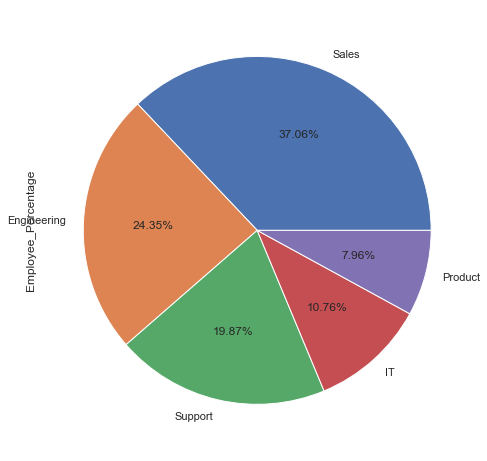

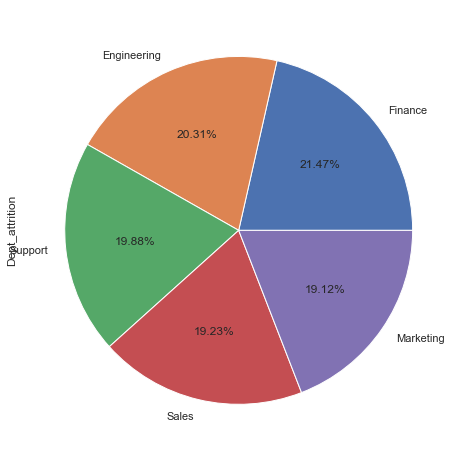

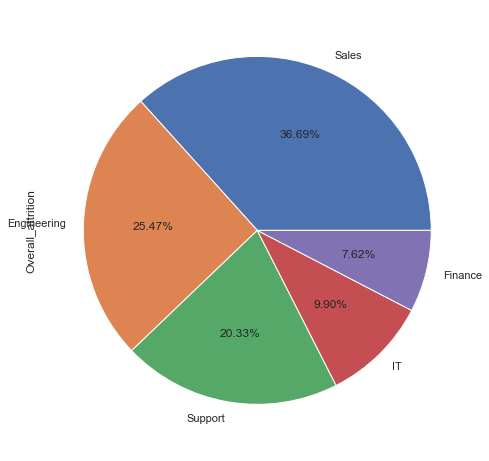

In [85]:
attrition_df.sort_values(by='Employee_Percentage', ascending=False).head(5).plot.pie('Employee_Percentage', legend=False, autopct='%.2f%%', figsize=(8,8))
attrition_df.sort_values(by='Dept_attrition', ascending=False).head(5).plot.pie('Dept_attrition', legend=False, autopct='%.2f%%', figsize=(8,8))
attrition_df.sort_values(by='Overall_attrition', ascending=False).head(5).plot.pie('Overall_attrition', legend=False, autopct='%.2f%%', figsize=(8,8))

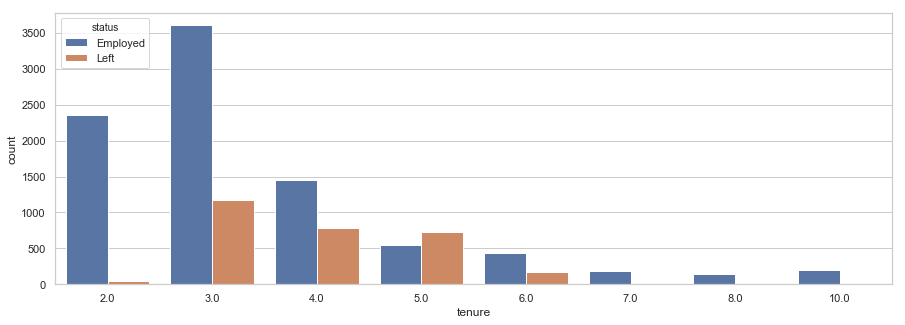

In [80]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='tenure', hue="status", data=df, ax=axis1)

In [81]:
df.to_csv('Employee_encoded_data.csv')

In [86]:
le = LabelEncoder()
df_copy = df.copy()
df['gender'] = le.fit_transform(df['gender'])
df['marital_status'] = le.fit_transform(df['marital_status'])
df['salary'] = le.fit_transform(df['salary'])
df['status'] = le.fit_transform(df['status'])
df['dept_name'] = le.fit_transform(df['dept_name'])

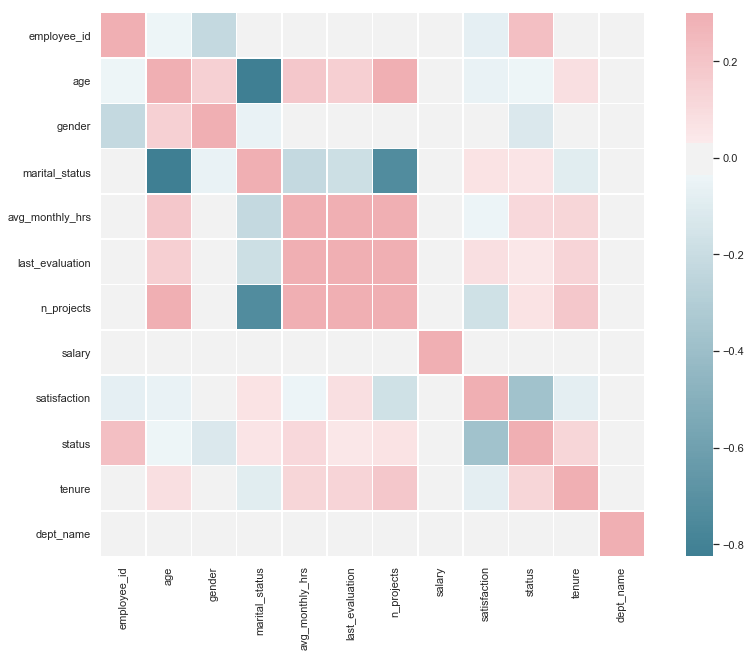

In [87]:
corr = df.corr()
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

C:\Users\Aditya\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Aditya\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


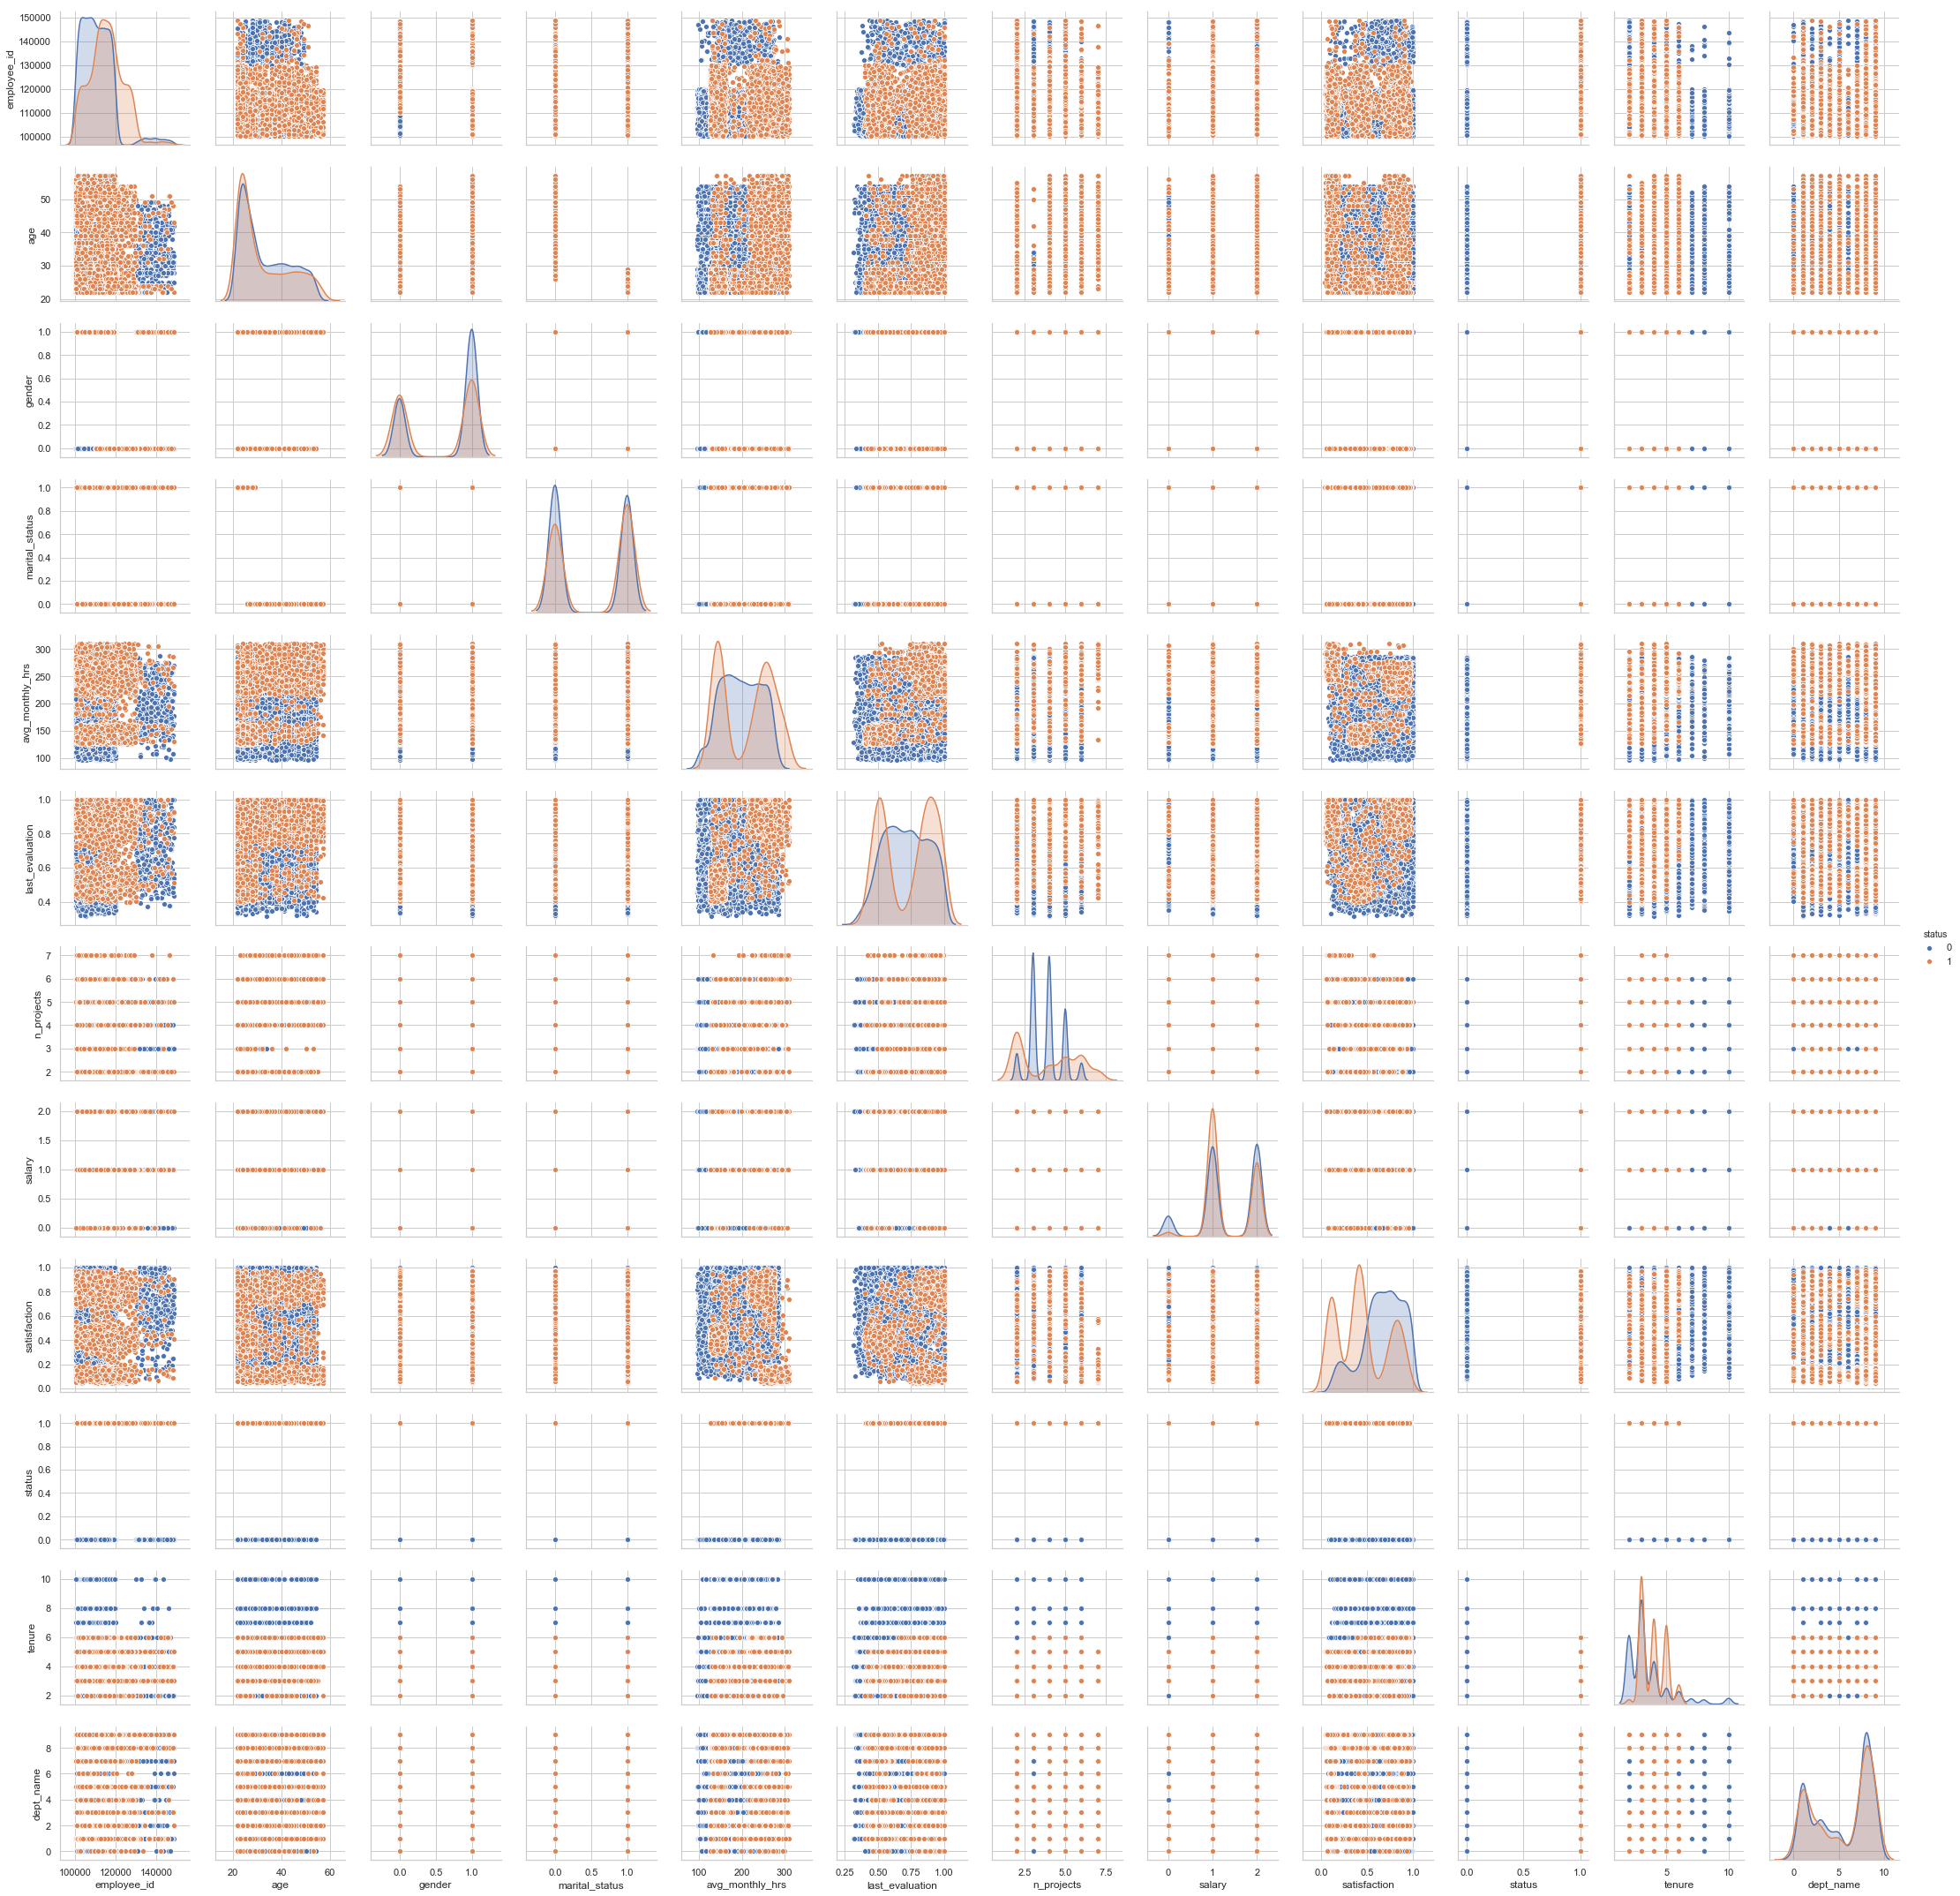

In [88]:
sns.pairplot(data=df,kind='scatter', hue='status')